# Imports

In [ ]:
!pip install hvplot

In [ ]:
import numpy as np
import pandas as pd
import hvplot.pandas
import os

In [112]:
from pathlib import Path
from numpy.random import seed
from joblib import dump, load

In [113]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [34]:
import tensorflow as tf
from tensorflow import random
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [5]:
# Set the random seed for reproducibility
seed(1)
random.set_seed(2)

# Data prep

In [6]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv(
    Path('/content/drive/MyDrive/Colab Notebooks/project_2/data/btc_historic.csv'), 
    index_col="Date", 
    infer_datetime_format=True, 
    parse_dates=True)

# Drop Adj Close
df = df[['Close']]
# df.head()

# Split data: train, test

In [8]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [9]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

feature_column = 0
target_column = 0
X, y = window_data(df, window_size, feature_column, target_column)

# Inspect type
print(f'Feature data type: {type(X)}\nTarget data type: {type(y)}')

Feature data type: <class 'numpy.ndarray'>
Target data type: <class 'numpy.ndarray'>


In [10]:
X.shape

(563, 10)

In [11]:
# Verify length, looks good
print(f'Feature data length: {len(X)}\nTarget data length: {len(y)}')

Feature data length: 563
Target data length: 563


In [12]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

# Scale Data

In [13]:
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()

In [14]:
# Fit and scale feature data
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# Fit and scale target data
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [16]:
# Reshape the features for the model
# Keras needs vertical vector
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define model: LSTM RNN

In [35]:
# Model params
number_units = 10
dropout_fraction = 0.2
epochs = 100

In [36]:
# Define LSTM RNN model
model = Sequential()

# Layer 1
model.add(LSTM(units=number_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

# Build and train model

In [55]:
# Compile the model
model.compile(
    optimizer="adam", 
    loss="mean_squared_error")

In [56]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 10)            480       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 10)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 10)            840       
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 10)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [ ]:
# Train the model
training_history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    shuffle=False, 
    batch_size=4, 
    verbose=1)

# Model Performance

In [58]:
# Evaluate the model
model.evaluate(X_test, y_test)

6/6 [==============================] - 2s 3ms/step - loss: 0.0035


0.0035420286003500223

In [59]:
# Make some predictions
predicted = model.predict(X_test)

In [60]:
type(predicted)

numpy.ndarray

In [61]:
predicted[0]

array([0.01384279], dtype=float32)

In [62]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [63]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel() }, 
    index = df.index[-len(real_prices): ])
    
stocks.head()

,Real,Predicted
Date,,
2019-02-11,3685.139893,3384.927490
2019-02-12,3611.340088,3430.118652
2019-02-13,3617.409912,3429.554443
2019-02-14,3605.870117,3415.832520
2019-02-15,3588.719971,3402.016113


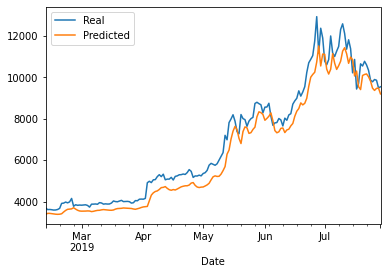

In [64]:
# Plot the real vs predicted values as a line chart
stocks.plot()

In [127]:
def print_model_summary_stats(actual, predicted, title):

  # Calculate r2_score (r-squared), should be close to 1
  r2 = r2_score(actual, predicted)

  # Calculate mean squared error, should be close to 0
  mse = mean_squared_error(actual, predicted)

  # Calculate root-mean-squared error (RMSE)
  rmse = np.sqrt(mse)

  print('==============================================================')
  print(title)
  print('==============================================================')
  print(f"R-squared (R2): {r2}")
  print(f"Mean Squared Error (MSE): {mse}")
  print(f"Root Mean Squared Error (RMSE): {rmse}")
  print(f"Standard Deviation of Futures Return: {np.std(predicted)}")

In [128]:
# Print model summary stats
print_model_summary_stats(y_test.ravel(), predicted.ravel(), 'LSTM Model')

LSTM Model
R-squared (R2): 0.9435464942922009
Mean Squared Error (MSE): 0.0035420283975580377
Root Mean Squared Error (RMSE): 0.05951494264097074
Standard Deviation of Futures Return: 0.2407514452934265


# Save model to disk

In [28]:
# Save the pre-trained model
model.save('/content/drive/MyDrive/Colab Notebooks/project_2/models/btc_lstm_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/project_2/models/btc_lstm_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/project_2/models/btc_lstm_model/assets


# Load model from disk and verify

In [29]:
# Load model from disk
reconstructed_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/project_2/models/btc_lstm_model')
type(reconstructed_model)

tensorflow.python.keras.engine.sequential.Sequential

In [30]:
# Make some predictions
predicted_2 = reconstructed_model.predict(X_test)

In [31]:
# Recover the original prices instead of the scaled version
predicted_prices_2 = scaler.inverse_transform(predicted_2.reshape(-1, 1))
real_prices_2 = scaler.inverse_transform(y_test.reshape(-1, 1))

In [32]:
# Create a DataFrame of Real and Predicted values
stocks_2 = pd.DataFrame({
    "Real": real_prices_2.ravel(),
    "Predicted": predicted_prices_2.ravel() }, 
    index = df.index[-len(real_prices_2): ])
    
stocks_2.head()

,Real,Predicted
Date,,
2019-02-11,3685.139893,3423.015625
2019-02-12,3611.340088,3484.374512
2019-02-13,3617.409912,3523.018066
2019-02-14,3605.870117,3535.560059
2019-02-15,3588.719971,3529.662109


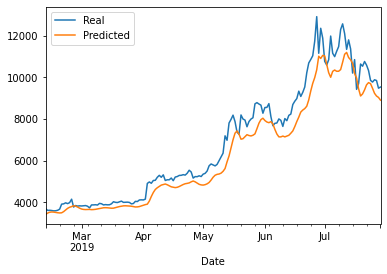

In [33]:
# Plot the real vs predicted values as a line chart
stocks_2.plot()

# Define model: Linear Regression

In [135]:
# Define LinearRegression model
model_2 = LinearRegression()

In [136]:
model.fit(X_train, y_train)

13/13 [==============================] - 0s 12ms/step - loss: 0.0023


In [137]:
# predicted = model.predict(X_test)
predicted_2 = model.predict(X_test)

In [138]:
# Recover the original prices instead of the scaled version
predicted_prices_2 = scaler.inverse_transform(predicted_2.reshape(-1, 1))

In [139]:
# Create a DataFrame of Real and Predicted values
stocks_2 = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices_2.ravel() }, 
    index = df.index[-len(real_prices): ])
    
stocks_2.head()

,Real,Predicted
Date,,
2019-02-11,3685.139893,3765.911377
2019-02-12,3611.340088,3814.787109
2019-02-13,3617.409912,3814.598877
2019-02-14,3605.870117,3800.376953
2019-02-15,3588.719971,3785.860352


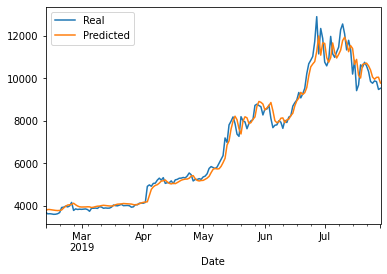

In [140]:
# Plot the real vs predicted values as a line chart
stocks_2.plot()

In [141]:
print_model_summary_stats(y_test.ravel(), predicted_2.ravel(), 'Linear Regression Model')

Linear Regression Model
R-squared (R2): 0.9804771595437589
Mean Squared Error (MSE): 0.0012249098515674211
Root Mean Squared Error (RMSE): 0.03499871214155488
Standard Deviation of Futures Return: 0.2470785528421402


In [143]:
# Save the pre-trained model
# model_2.save('/content/drive/MyDrive/Colab Notebooks/project_2/models/btc_linreg_model')

# Model comparison

In [132]:
print_model_summary_stats(y_test.ravel(), predicted.ravel(), 'LSTM Model')

LSTM Model
R-squared (R2): 0.9435464942922009
Mean Squared Error (MSE): 0.0035420283975580377
Root Mean Squared Error (RMSE): 0.05951494264097074
Standard Deviation of Futures Return: 0.2407514452934265


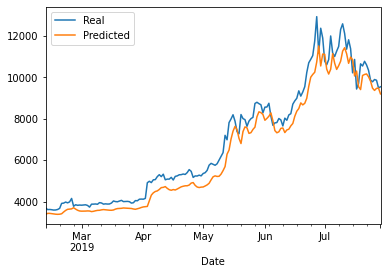

In [133]:
stocks.plot()

In [130]:
print_model_summary_stats(y_test.ravel(), predicted_2.ravel(), 'Linear Regression Model')

Linear Regression Model
R-squared (R2): 0.978158659559934
Mean Squared Error (MSE): 0.0013703781033523811
Root Mean Squared Error (RMSE): 0.037018618333919236
Standard Deviation of Futures Return: 0.24031506478786469


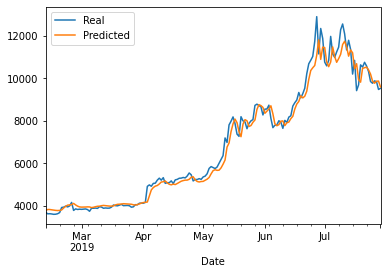

In [131]:
# Plot the real vs predicted values as a line chart
stocks_2.plot()